In [197]:
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from scipy import stats as sc
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
import pickle

In [13]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    
def rfFeaturePlot(rf_reg, col_list, plot=True, title="Feature importances"):
    importances = rf_reg.feature_importances_

    std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    if plot:
        # Plot the feature importances of the forest
        plt.figure(1,(12,9))
        plt.title(title)
        plt.bar(range(rf_reg.n_features_), importances[indices],  
               color="r", align="center")
        plt.xticks(range(rf_reg.n_features_),col_list[indices], rotation='vertical', fontsize=15)
#         plt.xlim([-1,rf_reg.n_features_)
        plt.xlim([-1, 20.5])
        plt.show()
        
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]

def plotPca(pca, Xtrain):
    plt.figure(1,(8,6))
    plt.bar(range(1, Xtrain.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, Xtrain.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xlim([0, 50])
    plt.show()
    
def get_important_features(transformed_features, components_, columns):
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)

In [70]:
complete_season_path = "master_data_ver2/all_season_master_data.csv"
complete_season_df = pd.read_csv(complete_season_path)

In [71]:
complete_season_df.iloc[:,:30]

,match_id,date,home_team_name,away_team_name,winner,home_goal,away_goal,goal_difference,home_team_team_rating,home_team_att_goal_low_left,...,home_team_att_miss_right,home_team_att_sv_low_centre,home_team_aerial_lost,home_team_accurate_pass,home_team_total_pass,home_team_won_corners,home_team_shot_off_target,home_team_ontarget_scoring_att,home_team_goals,home_team_att_miss_left
0,829513,16/08/2014 17:30:00,Arsenal,Crystal Palace,1,2,1,1,7.149141,1.250000,...,1.896552,2.173913,16.789474,452.894737,540.157895,6.891892,5.578947,6.135135,2.151515,2.030303
1,829514,18/08/2014 20:00:00,Burnley,Chelsea,-1,1,3,-2,6.785846,1.000000,...,1.680000,1.400000,24.631579,252.157895,358.815789,4.621622,4.789474,3.378378,1.400000,1.827586
2,829515,16/08/2014 15:00:00,Leicester,Everton,0,2,2,0,6.843094,1.454545,...,1.750000,1.650000,28.157895,249.684211,351.184211,5.578947,5.621622,3.805556,1.916667,2.172414
3,829516,17/08/2014 13:30:00,Liverpool,Southampton,1,2,1,1,6.902160,1.153846,...,1.800000,1.680000,15.526316,422.105263,509.815789,5.210526,6.131579,5.052632,1.733333,2.241379
4,829517,16/08/2014 12:45:00,Manchester United,Swansea,-1,1,2,-1,6.990919,1.294118,...,1.666667,1.960000,15.526316,477.368421,560.763158,5.631579,5.081081,4.864865,2.066667,2.000000
5,829518,17/08/2014 16:00:00,Newcastle United,Manchester City,-1,0,2,-2,6.740591,1.272727,...,1.758621,1.550000,23.000000,303.684211,395.263158,5.842105,5.078947,3.864865,1.600000,2.172414
6,829519,16/08/2014 15:00:00,Queens Park Rangers,Hull,-1,0,1,-1,6.765569,1.333333,...,1.689655,1.535714,23.894737,254.342105,359.421053,4.710526,5.657895,3.947368,1.615385,2.419355
7,829520,16/08/2014 15:00:00,Stoke,Aston Villa,-1,0,1,-1,6.868352,1.083333,...,1.851852,1.650000,19.026316,313.473684,404.710526,5.270270,5.756757,3.578947,1.655172,2.370370
8,829521,16/08/2014 15:00:00,West Bromwich Albion,Sunderland,0,2,2,0,6.765031,1.076923,...,1.666667,1.636364,17.000000,284.947368,379.842105,4.777778,4.552632,3.666667,1.520000,1.851852
9,829522,16/08/2014 15:00:00,West Ham,Tottenham,-1,0,1,-1,6.854401,1.076923,...,2.033333,1.523810,19.473684,266.342105,357.000000,6.513514,5.297297,4.108108,1.629630,2.093750


In [72]:
data_df = complete_season_df.drop(columns=['match_id', 'date', 'home_team_name', 'away_team_name'])
X_unp = data_df.iloc[:,4:]
y = data_df.iloc[:,0]

In [73]:
X_unp.shape, y.shape

((1520, 938), (1520,))

# Data Preprocess

In [74]:
X_v = variance_threshold_selector(X_unp, 0.7)
X_v.shape

(1520, 342)

In [20]:
X.columns

Index(['home_team_accurate_pass', 'home_team_total_pass',
       'home_player_1_fpl_minutes', 'home_player_3_fpl_points',
       'home_player_4_fpl_minutes', 'home_player_4_fpl_points',
       'home_player_6_fpl_minutes', 'home_player_6_fpl_points',
       'home_player_7_fpl_minutes', 'home_player_7_fpl_points',
       'home_player_8_fpl_minutes', 'home_player_8_fpl_points',
       'home_player_9_fpl_minutes', 'home_player_9_fpl_points',
       'home_player_10_fpl_minutes', 'home_player_10_fpl_points',
       'home_player_11_fpl_minutes', 'home_player_11_fpl_points',
       'away_team_accurate_pass', 'away_team_total_pass',
       'away_player_1_fpl_minutes', 'away_player_1_fpl_points',
       'away_player_2_fpl_points', 'away_player_3_fpl_points',
       'away_player_4_fpl_points', 'away_player_4_accurate_pass',
       'away_player_5_fpl_minutes', 'away_player_5_fpl_points',
       'away_player_6_fpl_minutes', 'away_player_6_fpl_points',
       'away_player_7_fpl_minutes', 'away_playe

In [75]:
# result_dict = {}
# for k_v in range(1, X_v.shape[1]+1):
#     X = kBestSelector(X_v, y, score_func = chi2, k = k_v)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
#     rbsc = RobustScaler()
#     X_train_rbs = rbsc.fit_transform(X_train.values)
#     X_test_rbs = rbsc.transform(X_test.values)
#     log_reg = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
#     log_reg.fit(X_train_rbs, y_train)
#     cv_scores = cross_val_score(log_reg, X_train_rbs, y_train, cv=5, n_jobs=-1)
#     result_dict[k_v] = (cv_scores, log_reg.score(X_train_rbs, y_train), np.mean(cv_scores), log_reg.score(X_test_rbs, y_test))
# #     print("CV SCORES:", cv_scores)
# #     print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_rbs, y_train))
# #     print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# #     print('TEST Accuracy: %.3f' % log_reg.score(X_test_rbs, y_test))
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


41 0.5482933239406551


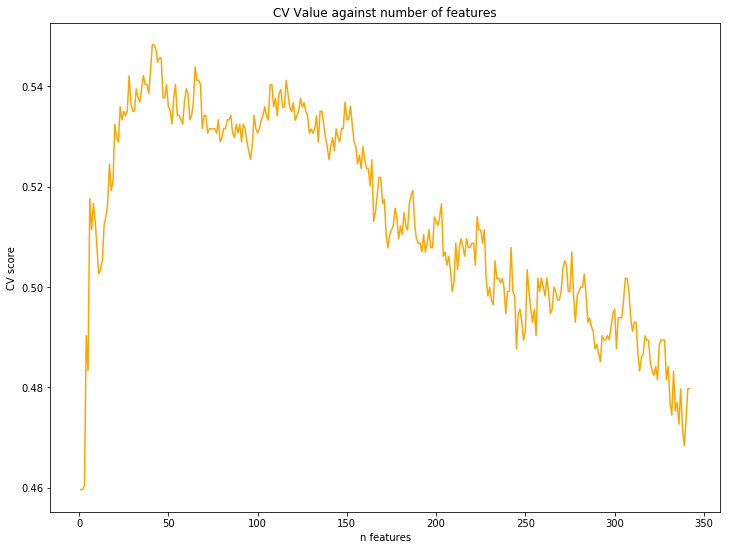

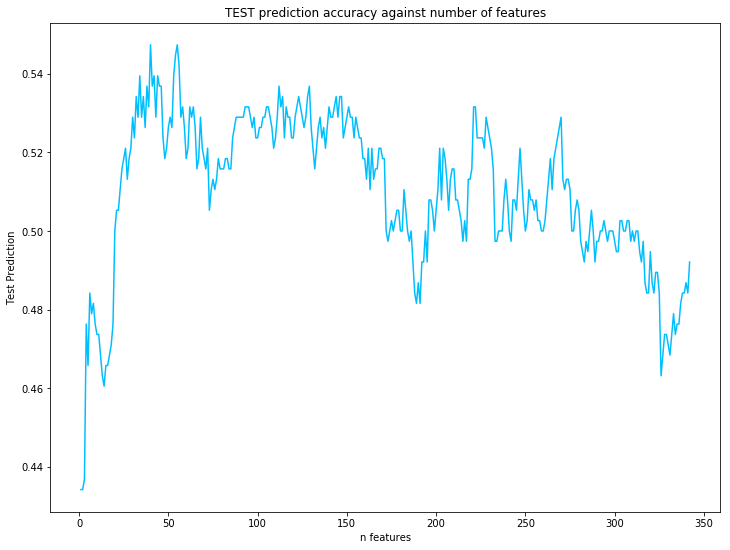

In [77]:
# max = float("-inf")
# fn = 0
# for k,v in result_dict.items():
# #     print(v, v[0])
#     if v[2] > max:
#         fn = k
#         max = v[2]
# print(fn, max)

# x_ax = []
# y_ax = []
# test_pred = []
# for k,v in result_dict.items():
#     x_ax.append(k)
#     y_ax.append(v[2])
#     test_pred.append(v[3])
# plt.figure(figsize=(12,9))
# plt.title('CV Value against number of features')
# plt.ylabel('CV score')
# plt.xlabel('n features')
# plt.plot(x_ax, y_ax, color='orange')
# plt.show()

# plt.figure(figsize=(12,9))
# plt.title('TEST prediction accuracy against number of features')
# plt.ylabel('Test Prediction')
# plt.xlabel('n features')
# plt.plot(x_ax, test_pred, color='deepskyblue')
# plt.show()

In [83]:
X = kBestSelector(X_v, y, score_func = chi2, k = fn)

# Data splitting

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)

In [85]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train.values)
X_test_std = stdsc.transform(X_test.values)

In [86]:
rbsc = RobustScaler()
X_train_rbs = rbsc.fit_transform(X_train.values)
X_test_rbs = rbsc.transform(X_test.values)

In [87]:
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train.values)
X_test_mm = mm.transform(X_test.values)

In [88]:
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train_mm)
# X_test = pca.transform(X_test_mm)
# plotPca(pca, X_train)

# Modeling

In [89]:
team_pred_model = LogisticRegression(penalty='l2', C=0.07, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(team_pred_model, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_rbs, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_rbs, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.54148472 0.56331878 0.51528384 0.56828194 0.55309735]
TRAINING Accuracy: 0.575
Average 5-Fold Training CV Score: 0.5482933239406551
TEST Accuracy: 0.537


In [262]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train, y_train)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


CV SCORES: [0.52083333 0.51388889 0.5        0.45454545 0.46478873 0.53900709
 0.56028369 0.4893617 ]
TRAINING Accuracy: 0.523
Average 8-Fold Training CV Score: 0.5053386114289433
TEST Accuracy: 0.495


In [263]:
log_reg = LogisticRegression(penalty='l2', C=0.0001, solver = 'lbfgs', multi_class='multinomial', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
log_reg.fit(X_train_std, y_train)
cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_std, y_train))
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % log_reg.score(X_test_std, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


CV SCORES: [0.45851528 0.45851528 0.45851528 0.47577093 0.46017699]
TRAINING Accuracy: 0.468
Average 5-Fold Training CV Score: 0.4622987535577917
TEST Accuracy: 0.442


In [264]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=20191027)
rfc.fit(X_train, y_train)
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test, y_test))

CV SCORES: [0.49344978 0.44104803 0.45414847 0.51982379 0.5       ]
Average 5-Fold Training CV Score: 0.4816940153511725
Accuracy: 0.458


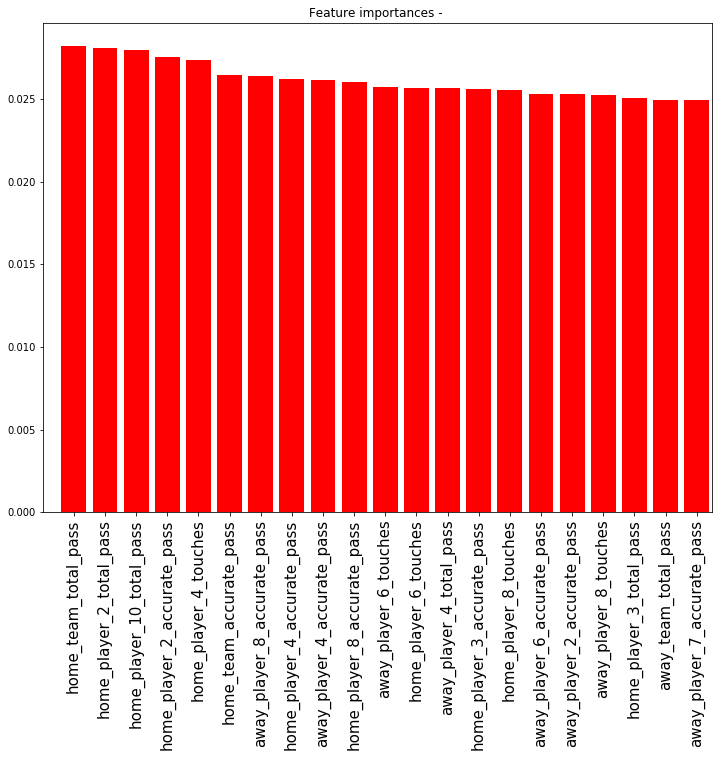

In [265]:
rfFeaturePlot(rfc, X.columns, title="Feature importances - ")

In [266]:
model = KNeighborsClassifier(n_neighbors = 20, algorithm = 'brute', n_jobs=-1)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.48471616 0.46724891 0.47598253 0.45374449 0.48230088]
Average 5-Fold Training CV Score: 0.4727985953202195
Accuracy: 0.429


In [267]:
model = GaussianNB()
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.45414847 0.47598253 0.4628821  0.44933921 0.44690265]
Average 5-Fold Training CV Score: 0.4578509924704792
Accuracy: 0.455


In [282]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.51965066 0.50218341 0.46724891 0.55947137 0.53539823]
Average 5-Fold Training CV Score: 0.5167905130319153
Accuracy: 0.482


In [269]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 50000000, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

[LibSVM]CV SCORES: [0.52838428 0.47598253 0.4628821  0.51101322 0.52212389]
Average 5-Fold Training CV Score: 0.5000772035922567
Accuracy: 0.466


In [270]:
model = SVC(C=0.5, kernel = 'rbf', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.49781659 0.48034934 0.48908297 0.56387665 0.50884956]
Average 5-Fold Training CV Score: 0.5079950235602892
Accuracy: 0.505


In [271]:
model = SVC(C=0.06, kernel = 'sigmoid', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_std, y_train)
cv_scores = cross_val_score(model, X_train_std, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.51528384 0.51528384 0.48908297 0.55947137 0.51769912]
Average 5-Fold Training CV Score: 0.5193642271409697
Accuracy: 0.500


In [272]:
model = SVC(C=0.01, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_rbs, y_train)
cv_scores = cross_val_score(model, X_train_rbs, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_rbs, y_test))

[LibSVM]CV SCORES: [0.50218341 0.50218341 0.48034934 0.56828194 0.53097345]
Average 5-Fold Training CV Score: 0.516794309371733
Accuracy: 0.487


In [273]:
model = SVC(C=0.08, kernel = 'linear', verbose = 1, max_iter = 5000000, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))

[LibSVM]CV SCORES: [0.48908297 0.51091703 0.48034934 0.55066079 0.52212389]
Average 5-Fold Training CV Score: 0.5106268063470035
Accuracy: 0.489


In [274]:
model = GradientBoostingClassifier(learning_rate = 0.05, random_state = 20191028)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test, y_test))

CV SCORES: [0.46724891 0.47598253 0.4628821  0.52422907 0.44690265]
Average 5-Fold Training CV Score: 0.47544905337500565
Accuracy: 0.461


In [275]:
model = GradientBoostingClassifier(learning_rate = 0.005, random_state = 20191028)
model.fit(X_train_mm, y_train)
cv_scores = cross_val_score(model, X_train_mm, y_train, cv=5, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 5-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % model.score(X_test_mm, y_test))

CV SCORES: [0.48471616 0.46724891 0.4628821  0.50660793 0.49115044]
Average 5-Fold Training CV Score: 0.48252110671306936
Accuracy: 0.487


# Doing prediction with goal scorer

team_pred_model : predicting match outcome <br>
goal_scorer_model: predicting chance of scoring

In [96]:
testing_idx_label = []
for idx, row in X_test.iterrows():
    testing_idx_label.append(idx)

In [141]:
master_path = "master_data_ver2/all_season_master_data_each_player_goals.csv"
master_df = pd.read_csv(master_path)
master_df = master_df.loc[testing_idx_label, :]

In [142]:
with open('pickle_models/scoring_prob_model.pickle', 'rb') as handle:
    goal_scorer_model =  pickle.load(handle)
with open('pickle_models/scoring_prob_model_stdsc.pickle', 'rb') as handle:
    stdsc_player =  pickle.load(handle)

In [145]:
team_match_col = ['home_team_accurate_pass', 'home_team_total_pass', 'home_player_1_fpl_minutes', 'home_player_3_fpl_points', 'home_player_4_fpl_minutes', 'home_player_4_fpl_points','home_player_6_fpl_minutes', 'home_player_6_fpl_points','home_player_7_fpl_minutes', 'home_player_7_fpl_points','home_player_8_fpl_minutes', 'home_player_8_fpl_points','home_player_9_fpl_minutes', 'home_player_9_fpl_points','home_player_10_fpl_minutes', 'home_player_10_fpl_points','home_player_11_fpl_minutes', 'home_player_11_fpl_points','away_team_accurate_pass', 'away_team_total_pass','away_player_1_fpl_minutes', 'away_player_1_fpl_points','away_player_2_fpl_points', 'away_player_3_fpl_points','away_player_4_fpl_points', 'away_player_4_accurate_pass','away_player_5_fpl_minutes', 'away_player_5_fpl_points','away_player_6_fpl_minutes', 'away_player_6_fpl_points','away_player_7_fpl_minutes', 'away_player_7_fpl_points','away_player_8_fpl_minutes', 'away_player_8_fpl_points','away_player_8_accurate_pass', 'away_player_9_fpl_minutes','away_player_9_fpl_points', 'away_player_10_fpl_minutes','away_player_10_fpl_points', 'away_player_11_fpl_minutes','away_player_11_fpl_points']
goal_scorer_col = ['fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_points', 'fpl_bonus', 'formation_place']

In [104]:
X_test

,home_team_accurate_pass,home_team_total_pass,home_player_1_fpl_minutes,home_player_3_fpl_points,home_player_4_fpl_minutes,home_player_4_fpl_points,home_player_6_fpl_minutes,home_player_6_fpl_points,home_player_7_fpl_minutes,home_player_7_fpl_points,...,away_player_7_fpl_points,away_player_8_fpl_minutes,away_player_8_fpl_points,away_player_8_accurate_pass,away_player_9_fpl_minutes,away_player_9_fpl_points,away_player_10_fpl_minutes,away_player_10_fpl_points,away_player_11_fpl_minutes,away_player_11_fpl_points
1472,277.429559,389.299589,1320.25500,37.70000,2257.45300,71.74900,1277.10000,57.30000,1365.00000,41.00000,...,78.36773,2797.89202,101.08639,22.695954,2685.04200,135.10100,609.00000,31.00000,2241.00000,107.00000
1363,278.920781,382.235606,2297.19618,55.33691,2297.28211,96.98171,2358.11848,95.85824,2522.50000,113.40000,...,87.00000,735.00000,25.00000,14.200000,221.00000,16.00000,1779.49800,93.70200,1976.00000,101.00000
301,211.416615,302.043555,2520.00000,95.00000,1255.00000,44.00000,3052.00000,105.00000,2357.00000,58.00000,...,67.00000,3029.00000,103.00000,28.217592,2372.00000,98.00000,1943.00000,71.00000,1419.00000,64.00000
89,252.853673,354.470814,3183.00000,74.00000,2131.00000,64.00000,1382.00000,61.00000,2504.00000,57.00000,...,95.00000,1570.00000,78.00000,58.440000,1879.00000,67.00000,2353.00000,134.00000,2532.00000,216.00000
326,408.993947,513.119786,617.00000,140.00000,3146.00000,142.00000,2186.00000,90.00000,2261.00000,88.00000,...,75.00000,2300.00000,93.00000,41.312812,3132.00000,162.00000,2193.00000,55.00000,2581.00000,191.00000
1011,326.855160,431.411943,1796.10000,35.00000,3420.00000,121.00000,2804.00000,70.00000,2695.00000,77.00000,...,82.86800,1042.00000,55.00000,22.885800,1560.50000,49.30000,1286.75200,70.09800,2320.20000,130.20000
458,210.524070,327.876374,3042.00000,130.90000,2711.00000,150.00000,2568.80000,102.00000,2748.90000,198.60000,...,118.20000,2010.00000,104.20000,26.253239,1761.70000,45.40000,1879.80000,88.50000,1973.00000,155.00000
401,368.377603,447.823856,2256.50000,131.40000,2983.60000,126.40000,2547.00000,142.70000,2639.50000,125.70000,...,108.00000,187.00000,18.00000,6.363636,2748.90000,198.60000,1156.20000,54.90000,2865.40000,183.70000
1074,271.572203,361.025494,1454.40000,77.60000,1330.00000,55.00000,1143.00000,43.00000,1273.00000,34.00000,...,91.00000,1138.00000,40.90000,12.892551,2543.40000,101.90000,2872.00000,130.00000,873.80000,38.10000
624,338.296808,419.908398,3249.90000,92.80000,2200.40000,107.20000,1385.00000,93.50000,1257.40000,47.00000,...,78.20000,2419.60000,74.80000,34.378633,2741.50000,133.10000,2832.50000,73.00000,3080.60000,170.00000


In [105]:
team_pred_model.predict(X_test[:1])

array([1], dtype=int64)

In [161]:
match_prob = team_pred_model.predict_proba(X_test_rbs)

In [192]:
verbose = {}
for i, (idx, row) in enumerate(master_df.iterrows()):
    verbose[idx] = {}
    verbose[idx]['actual'], verbose[idx]['pred_prob'] = {}, {}
    verbose[idx]['actual']['actual_winner'] = row['winner']
    for i in range(1,12):
        player_col = "home_player_"+str(i)+"_match_goal"
        verbose[idx]['actual']['actual_home_player_'+str(i)+'_goal'] = row[player_col]
    for i in range(1,12):    
        player_col = "away_player_"+str(i)+"_match_goal"
        verbose[idx]['actual']['actual_away_player_'+str(i)+'_goal'] = row[player_col]
        
        
    verbose[idx]['pred_prob']['away_win_prob'] = match_prob[i][0]
    verbose[idx]['pred_prob']['draw'] = match_prob[i][1]
    verbose[idx]['pred_prob']['home_win_prob'] = match_prob[i][2]
    
    for i in range(1,12):
        player_col = []
        for p_col in goal_scorer_col:
            player_col.append("home_player_"+str(i)+"_"+p_col)
        loc_player_df = master_df.loc[idx][player_col].astype(float)
        player_X = stdsc_player.transform(loc_player_df.values.reshape(1,-1))
        verbose[idx]['pred_prob']['predicted_home_player_'+str(i)+'_to_score'] = goal_scorer_model.predict_proba(player_X)[0][1]
    for i in range(1,12):
        player_col = []
        for p_col in goal_scorer_col:
            player_col.append("away_player_"+str(i)+"_"+p_col)
        loc_player_df = master_df.loc[idx][player_col].astype(float)
        player_X = stdsc_player.transform(loc_player_df.values.reshape(1,-1))
        verbose[idx]['pred_prob']['predicted_away_player_'+str(i)+'_to_score'] = goal_scorer_model.predict_proba(player_X)[0][1]

In [198]:
with open('verbose_statistic.json', 'w') as fp:
    json.dump(verbose, fp)
